In [4]:
import torch
import torch.nn as nn
from face_classifier import *
import warnings
from Models.resnet import FaceKeypointResNet50
from cnn_utils import *
import zipfile

warnings.filterwarnings("ignore")

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## This notebook train the Resnet 50 Pretrained Model using the IMM Image Database
### Code written by Luke Banaszak or Rick Suggs unless otherwise noted

In [6]:
print(f"GPU acceleration is available: {torch.cuda.is_available()}")

resnet50_model = FaceKeypointResNet50(True, True)
if torch.cuda.is_available():
    resnet50_model.cuda()

GPU acceleration is available: True
Training intermediate layer parameters...


# Data Pipeline

In [7]:

imagedir = "./Data"
with zipfile.ZipFile('./Images.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

header = ["path", "type", "xrel", "yrel", "point", "connects_from", "connects_to"]
skiprows = np.hstack((np.arange(0, 16), np.arange(75, 81)))
directory = os.fsencode(imagedir)
frame = build_frame(
    directory=directory, imagedir=imagedir, header=header, skiprows=skiprows
)

In [8]:
# Put together the transformations we'll perform on the input images
composed = transforms.Compose([Rescale((120, 160)), NormalizeZeroToOne(), ToTensor()])

In [9]:
total_images = len(frame.index.unique())
print(f"Total images: {total_images}")
test_frac = 0.10

valid_split = int(total_images * test_frac)
train_split = int(total_images - valid_split)

training_samples = frame.loc[: train_split - 1]
testing_samples = frame.loc[train_split:]

train_data = FaceLandmarksDataset(frame=training_samples, root_dir=imagedir, transform=composed)
test_data = FaceLandmarksDataset(frame=testing_samples, root_dir=imagedir, transform=composed)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(test_data)}")

Total images: 240
Training sample instances: 216
Validation sample instances: 24


## DataLoaders

In [10]:
from torch.utils.data import DataLoader

# Create a dataloader for dataset we created - decide on batch size
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False,
    num_workers=0,
    sampler=range(testing_samples.index.min(), testing_samples.index.max()),
)

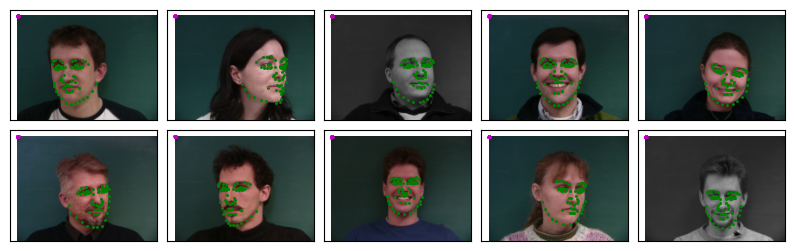

In [11]:
for test_images, test_outputs, gt_pts in net_sample_output(
    resnet50_model, train_dataloader
):
    visualize_output(test_images, test_outputs, gt_pts)

# Optimizer and Training

In [12]:
# Define loss function as mean squared error
# Use ADAM algorithm as optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0003, fused=True)

In [ ]:
# WARNING! This cell takes several minutes to execute
# The trained model can be downloaded from https://drive.google.com/file/d/18B-OyNvhSzki7BPGcgzI2pi1BBssM89b
# and unzipped to the nets folder. Scroll down 4 cells and it can be loaded from the saved model file.
training_loss, validation_loss = train_and_validate(
    resnet50_model, train_dataloader, optimizer, criterion, test_dataloader, 25
)

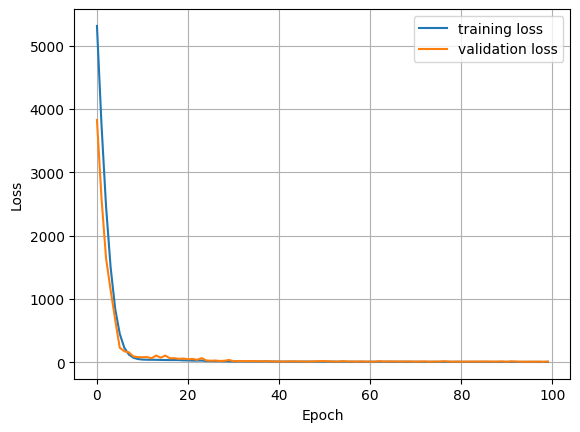

In [11]:
plt.figure()
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

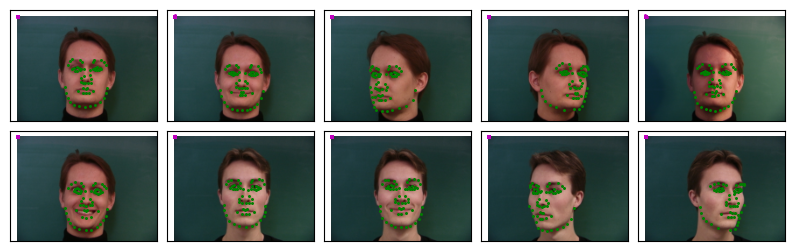

In [13]:
for test_images, test_outputs, gt_pts in net_sample_output(
    resnet50_model, test_dataloader
):
    visualize_output(test_images, test_outputs, gt_pts)

In [14]:
state = {
    "epoch": 25,
    "model_state_dict": resnet50_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": criterion,
}
torch.save(state, "nets/resnet50-2_landmarks.pth")

Training intermediate layer parameters...


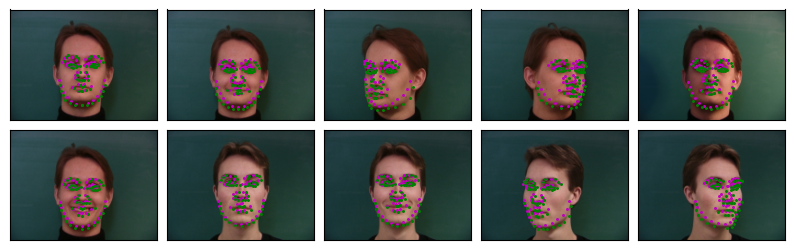

In [13]:
# The trained model can be downloaded from https://drive.google.com/file/d/18B-OyNvhSzki7BPGcgzI2pi1BBssM89b
# and unzipped to the ./NeuralNet/nets folder.
best_network = FaceKeypointResNet50(True, True)
checkpoint = torch.load("nets/resnet50-2_landmarks.pth")
best_network.load_state_dict(checkpoint["model_state_dict"])
if torch.cuda.is_available():
    best_network.cuda()
best_network.eval()

for test_images, test_outputs, gt_pts in net_sample_output(
    best_network, test_dataloader
):
    visualize_output(test_images, test_outputs, gt_pts)

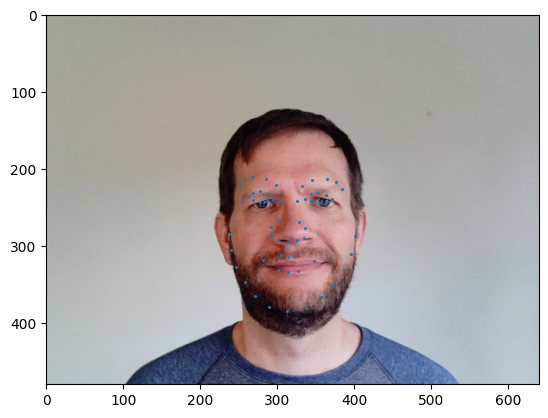

In [14]:
my_image = plt.imread("../FaceMorphing/images/rick_640x480.jpg").astype(np.float32)
predicted_key_pts = get_predicted_keypoints(my_image, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/rick_640x480_predicted_points.npy",
    predicted_key_pts.T,
)

plt.imshow(my_image.astype(np.uint8))
plt.scatter(*predicted_key_pts, s=5, marker=".")

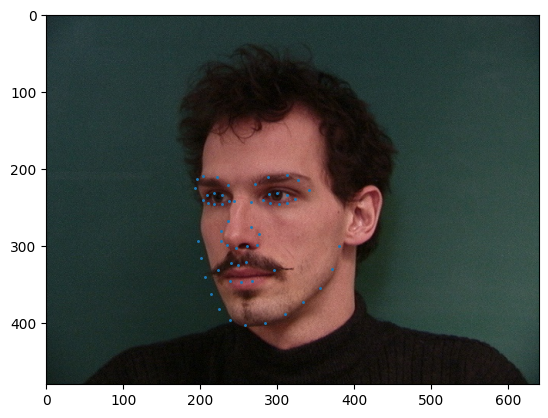

In [15]:
other_image = plt.imread("Data/10-3m.jpg").astype(np.float32)

other_predicted_key_pts = get_predicted_keypoints(other_image, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/10-3m_predicted_points.npy", other_predicted_key_pts.T
)

plt.imshow(other_image.astype(np.uint8))
plt.scatter(*other_predicted_key_pts, s=5, marker=".")

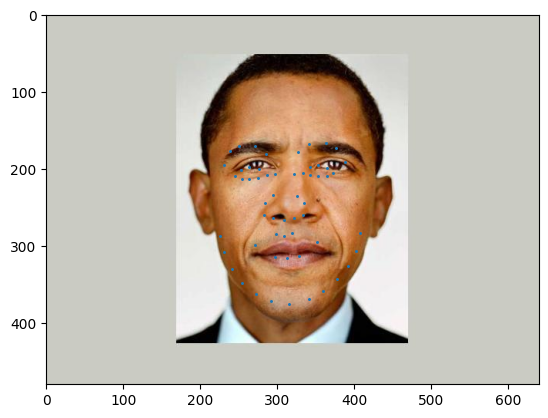

In [16]:
barack = plt.imread("../FaceMorphing/images/barack_640x480.jpg").astype(np.float32)

predicted_key_pts = get_predicted_keypoints(barack, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/barack_640x480_predicted_points.npy",
    predicted_key_pts.T,
)

plt.imshow(barack.astype(np.uint8))
plt.scatter(*predicted_key_pts, s=5, marker=".")

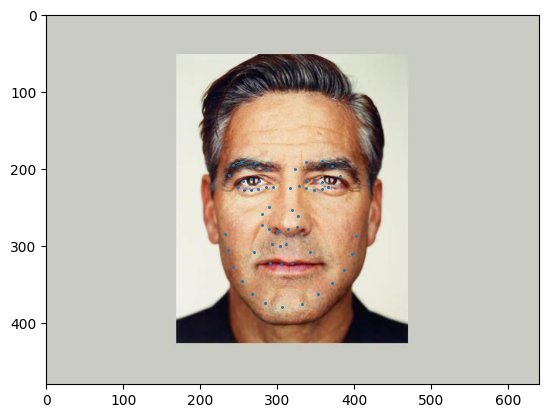

In [17]:
george = plt.imread("../FaceMorphing/images/george_640x480.jpg").astype(np.float32)

predicted_key_pts = get_predicted_keypoints(george, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/george_640x480_predicted_points.npy",
    predicted_key_pts.T,
)

plt.imshow(george.astype(np.uint8))
plt.scatter(*predicted_key_pts, s=5, marker=".")

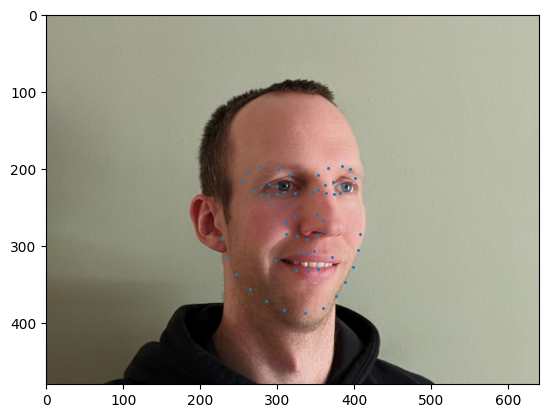

In [18]:
tlb1 = plt.imread("../FaceMorphing/images/tlb1_640x480.jpg").astype(np.float32)

predicted_key_pts = get_predicted_keypoints(tlb1, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/tlb1_640x480_predicted_points.npy",
    predicted_key_pts.T,
)

plt.imshow(tlb1.astype(np.uint8))
plt.scatter(*predicted_key_pts, s=5, marker=".")

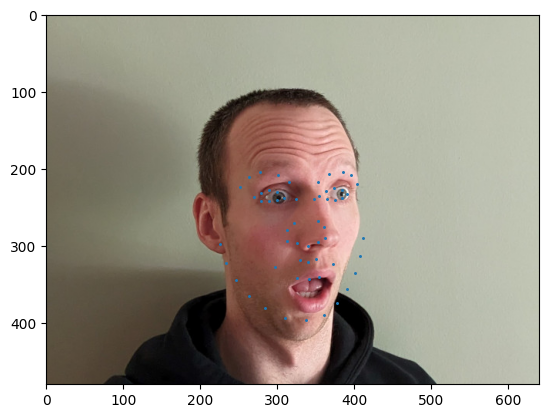

In [19]:
tlb2 = plt.imread("../FaceMorphing/images/tlb2_640x480.jpg").astype(np.float32)

predicted_key_pts = get_predicted_keypoints(tlb2, composed, best_network)

np.save(
    "../FaceMorphing/keypoints/tlb2_640x480_predicted_points.npy",
    predicted_key_pts.T,
)

plt.imshow(tlb2.astype(np.uint8))
plt.scatter(*predicted_key_pts, s=5, marker=".")